## Initial Setup

In [1]:
# Initial setup...
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import fitsio
from scipy import interpolate
import glob
import math
import os

import h5py
import bisect

import matplotlib.pyplot as plt

%matplotlib inline


## User input

In [2]:
# debug=True fits a single spectrum with a smaller set of models and over a smaller range of redshifts...
debug=False

# Directory name for the IRAF-reduced spectra:
inputFile_obs_dirname = '/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF'

# Output directory...
output_dirname = '/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_analysis/FigOutput'

if not debug:

    inputFile_obs_list = ['fc_AT2019nte_host_400Cus.fits',
                          'fc_AT2019omw_400Cus_comb.fits']
    
    cleanName_obs_dict = {'fc_AT2019nte_host_400Cus.fits': 'AT2019nte*',
                          'fc_AT2019omw_400Cus_comb.fits': 'AT2019omw*'}
    
    z_dict             = {'fc_AT2019nte_host_400Cus.fits': 0.0704,
                          'fc_AT2019omw_400Cus_comb.fits': 0.0467}

else:

    inputFile_obs_list = ['fc_AT2019nte_host_400Cus.fits']
    
    cleanName_obs_dict = {'fc_AT2019nte_host_400Cus.fits': 'AT2019nte*'}
    
    z_dict             = {'fc_AT2019nte_host_400Cus.fits': 0.0467}


## Plot function

In [3]:
def plot_obs_host_gal(obsname, obsname_clean, z, wavelength_array, df_obs_new, output_dirname):

    ax = df_obs_new.plot('LAMBDA', 'normFLUX', c='#56b4e9', alpha=0.8, label='Observed', fontsize=18)
    title = """%s""" % (obsname_clean)
    plt.title(title, fontsize=35)
    ax.legend(loc='upper right', fontsize=14, framealpha=0.5)
    ax.set_xlabel('wavelength (observed frame) [$\\AA$]',fontsize=16)
    ax.set_ylabel('Relative $F_{\lambda}$',fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    textstr = """$z_{best}$=%.3f""" % (z)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax.grid(False)
    
    outputFile = """HostGal.%s.png""" % (obsname_clean)
    outputFile = os.path.join(output_dirname, outputFile)
    
    plt.tight_layout()
    plt.savefig(outputFile)

    return 0


## Fit each input observed spectrum


/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF/fc_AT2019nte_host_400Cus.fits
/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF/fc_AT2019nte_host_400Cus.csv
fc_AT2019nte_host_400Cus.fits
Filename: /data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF/fc_AT2019nte_host_400Cus.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     323   (2001,)   float32   

/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF/fc_AT2019omw_400Cus_comb.fits
/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF/fc_AT2019omw_400Cus_comb.csv
fc_AT2019omw_400Cus_comb.fits
Filename: /data/des40.a/data/dtucker/DESGW_analysis/S190814bv_IRAF/fc_AT2019omw_400Cus_comb.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     323   (2001,)   float32   


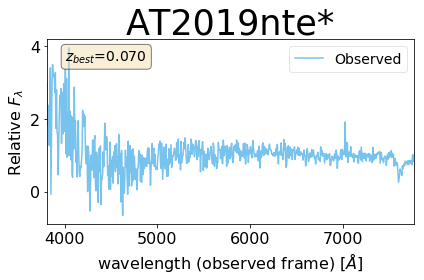

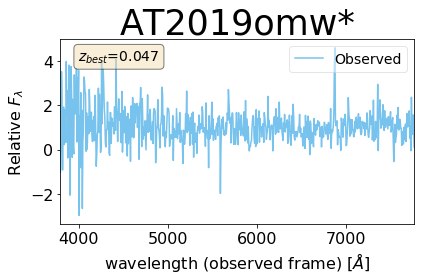

In [7]:
for inputFile_obs in inputFile_obs_list:
    
    fullInputFile_obs = os.path.join(inputFile_obs_dirname, inputFile_obs)
    print 
    print fullInputFile_obs
    outputCSVFile = os.path.splitext(fullInputFile_obs)[0]+".csv"
    print outputCSVFile

    
    obsname = os.path.basename(inputFile_obs)
    print obsname 
    obsname_clean = cleanName_obs_dict[inputFile_obs]

    hdulist = fits.open(fullInputFile_obs)
    hdulist.info()
    data0 = hdulist[0].data
    hdr0 = hdulist[0].header

    wave0_lo = hdr0['CRVAL1']
    wave0_hi = hdr0['CRVAL1'] + hdr0['CD1_1']*(data0.size)
    wave0 = np.arange(wave0_lo, wave0_hi, hdr0['CD1_1'])

    df_obs = pd.DataFrame({'LAMBDA':wave0, 'FLUX':data0}) 
    df_obs.to_csv(outputCSVFile, index=False)
            
    lambda_lo = df_obs.LAMBDA.min()
    lambda_hi = df_obs.LAMBDA.max()

    #wavelength_array = np.arange(lambda_lo, lambda_hi, 10.)
    wavelength_array = np.arange(lambda_lo, lambda_hi, 6.)
    
    spec_flux_obs = interpolate.interp1d(df_obs.LAMBDA, df_obs.FLUX,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_obs_array = spec_flux_obs(wavelength_array)

    df_obs_new = pd.DataFrame({'LAMBDA':wavelength_array, 'FLUX':spec_flux_obs_array})

    norm = df_obs_new['FLUX'].median()
    df_obs['normFLUX'] = df_obs['FLUX']/norm
    df_obs_new['normFLUX'] = df_obs_new['FLUX']/norm

    z = z_dict[inputFile_obs]
    status = plot_obs_host_gal(obsname, obsname_clean, z, wavelength_array, df_obs_new, output_dirname)
    
    #print obsname, obsname_clean, z, output_dirname